This notebook demonstrates how to perform hyperparameter optimization for every machine learning model and compare the model performance of different combination of descriptor and machine learning model.

# Load Dependencies

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.metrics import mean_absolute_error,r2_score
import torch
import pandas as pd
from scipy.stats import pearsonr
from xgboost import XGBRegressor
from itertools import product
from torch import nn
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from utils.ModelTraining import TorchDataset,NeuralNetwork,init_model,oos_fit_pred,cv_fit_pred,\
feature_selection,model_evaluation,cv_fit_pred_NN,oos_fit_pred_NN

%matplotlib notebook
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
random_seed = 2022
device

device(type='cuda', index=0)

# Load Descriptors

Load the physorg descriptors and other descriptors, which have been performed max-min scaling.

In [2]:
physorg_desc_npz = np.load('./descriptors/physorg_desc.npz',allow_pickle=True)
physorg_react_desc = physorg_desc_npz['react_desc']
physorg_react_desc_name = physorg_desc_npz['react_desc_name']
other_descs_for_benchmark_npz = np.load('./descriptors/other_descs_for_benchmark.npz',allow_pickle=True)
onehot_react_desc = other_descs_for_benchmark_npz['onehot_react_desc']
rdkit_react_desc = other_descs_for_benchmark_npz['rdkit_react_desc']
mf_react_desc = other_descs_for_benchmark_npz['mf_react_desc']

lmbtr_react_desc = other_descs_for_benchmark_npz['lmbtr_react_desc']
mbtr_react_desc = other_descs_for_benchmark_npz['mbtr_react_desc']
ddG = pd.read_csv('./datasets/dataset.csv',index_col=0)['ddG(kcal/mol)'].to_numpy()


Details of the physorg descriptors.

**Note:** 'HF' in the tag in the descriptor name means Hirshfeld

In [3]:
physorg_react_desc_df = pd.DataFrame(physorg_react_desc)
physorg_react_desc_df.columns = physorg_react_desc_name
physorg_react_desc_df

,q_HF_+1-a16-Imine-CH-GS,q_HF_+1-a15-Imine-AI-GS,q_HF_+1-a15-Imine-CH-R,q_HF_0-a15-Imine-CH-GS,q_HF_0-a15-Imine-AI-R,q_HF_0-a16-Imine-CH-GS,s_HF_0-a15-Imine-CH-R,q_HF_+1-a15-Imine-AI-R,s_HF_-1-a0-Olefin-AI-R,q_HF_0-a0-Olefin-AI-R,...,Sol XLogP3-AA 2,Sol Topological Polar Surface Area Å² 2,Sol Density (g/mL) 2,Sol Molar Volume (mL/mol) 2,Sol Refractive Index 2,Sol Dipole Moment (D) 2,Sol Melting Point (°C) 2,Sol Boiling Point (°C) 2,Temperature,Current
0,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.127431,0.767013,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.375
1,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.127431,0.767013,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.0
2,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.127431,0.767013,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.375
3,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.127431,0.767013,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,1.0
4,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.127431,0.767013,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.418204,0.173284,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.375
123,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.436106,0.828172,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.25
124,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.156559,0.767181,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.375
125,0.207299,0.160786,0.039966,1.0,0.523177,0.956873,0.918168,0.0,0.127431,0.767013,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.375


# Hyperparameter Optimization

**Grid search** method is used to identify the optimal model paramters for every combination of model and descriptor. We select the key parameters for every machine learning model to perform hyperparameter optimization and the other parameters use the default settings.

In [4]:
param_grid = {'RF':{'n_estimators':[100,200,300,400,500,600],'max_depth': [None, 5, 10, 15, 20]},
              'ET':{'n_estimators':[100,200,300,400,500,600],'max_depth': [None, 5, 10, 15, 20]},
              'KNN':{'n_neighbors':[5,10,15],'leaf_size':[25,30,35]},
              'DT':{'max_depth':[None,10,20,],'min_samples_split':[2,4,6]},
              'SVR':{'kernel':['rbf', 'linear', 'poly'],'gamma':['scale','auto']},
              'KRR':{'gamma':[None,0.01,0.001,0.0001]}
                }

models = [RandomForestRegressor(n_jobs=-1,random_state=random_seed),
          ExtraTreesRegressor(n_jobs=-1,random_state=random_seed),
          KNeighborsRegressor(n_jobs=-1),
          DecisionTreeRegressor(random_state=random_seed),
          SVR(),
          KernelRidge()]
model_names = ['RF','ET','KNN','DT','SVR','KRR']

descs = [physorg_react_desc,onehot_react_desc,rdkit_react_desc,mf_react_desc,lmbtr_react_desc,mbtr_react_desc]
desc_names = ['PhysOrg','OneHot','RDKit','MF','LMBTR','MBTR']
best_params = {}
performance_result = {}

'''
The "test_index" is the index of the out-of-sample (OOS) test set, which should be excluded 
during the cross-validation procedure. 

OOS test set: 28 compounds (7 biaryls, 14 olefins and 7 TDGs) have only one associated 
transformation, and these transformations are selected out of the original dataset as 
the out-of-sample (OOS) test set. The details of 28 data can be found in Notebook 4.
'''
test_index = [15,21,31,52,56,58,59,65,96,104,105,106,107,108,109,
              110,111,112,113,114,115,120,121,122,123,124,125,126]
train_val_index = list(set(range(len(physorg_react_desc))) - set(test_index))
kfold = KFold(n_splits=10,shuffle=True,random_state=random_seed)
for model_name,model in zip(model_names,models):
    for desc_name,desc in zip(desc_names,descs):

        train_val_desc,train_val_target = desc[train_val_index],ddG[train_val_index]
        GS = GridSearchCV(model,param_grid[model_name],cv=kfold,n_jobs=-1,scoring='r2')
        GS.fit(train_val_desc,train_val_target)
        best_param = GS.best_params_
        best_score = GS.best_score_
        best_params[(model_name,desc_name)] = best_param
        print('Model: %4s, Desc: %s, Best Socre: %.4f, Best Param: '%(model_name,desc_name,best_score),best_param)

Model:   RF, Desc: PhysOrg, Best Socre: 0.8779, Best Param:  {'max_depth': 5, 'n_estimators': 100}
Model:   RF, Desc: OneHot, Best Socre: 0.8552, Best Param:  {'max_depth': 10, 'n_estimators': 100}
Model:   RF, Desc: RDKit, Best Socre: 0.8682, Best Param:  {'max_depth': 5, 'n_estimators': 200}
Model:   RF, Desc: MF, Best Socre: 0.8503, Best Param:  {'max_depth': 10, 'n_estimators': 100}
Model:   RF, Desc: LMBTR, Best Socre: 0.8621, Best Param:  {'max_depth': 5, 'n_estimators': 100}
Model:   RF, Desc: MBTR, Best Socre: 0.8650, Best Param:  {'max_depth': 5, 'n_estimators': 100}
Model:   ET, Desc: PhysOrg, Best Socre: 0.8850, Best Param:  {'max_depth': 10, 'n_estimators': 400}
Model:   ET, Desc: OneHot, Best Socre: 0.8828, Best Param:  {'max_depth': 10, 'n_estimators': 100}
Model:   ET, Desc: RDKit, Best Socre: 0.8708, Best Param:  {'max_depth': 10, 'n_estimators': 100}
Model:   ET, Desc: MF, Best Socre: 0.8854, Best Param:  {'max_depth': 10, 'n_estimators': 600}
Model:   ET, Desc: LMBTR,

As the incompatibility of **xgboost**/**pytorch** and scikit-learn built-in grid search method, we use the naive code to implement same function.

In [5]:
params = {'n_estimators':[100,200,300,400,500,600],'max_depth': [None, 5, 10, 15, 20]}

for desc_name,desc in zip(desc_names,descs):
    result = []
    for n_e,m_d in product(params['n_estimators'],params['max_depth']):
    
        model = XGBRegressor(n_estimators=n_e,max_depth=m_d,n_jobs=-1,random_state=random_seed)
        all_test_p = []
        all_test_y = []
        train_val_desc,train_val_target = desc[train_val_index],ddG[train_val_index]
        for train_idx,test_idx in kfold.split(train_val_desc):
            train_x,test_x = train_val_desc[train_idx],train_val_desc[test_idx]
            train_y,test_y = train_val_target[train_idx],train_val_target[test_idx]
            model.fit(train_x,train_y)
            all_test_p.append(model.predict(test_x))
            all_test_y.append(test_y)
        all_test_p = np.concatenate(all_test_p,axis=0)
        all_test_y = np.concatenate(all_test_y,axis=0)
        mae = mean_absolute_error(all_test_y,all_test_p)
        r2 = r2_score(all_test_y,all_test_p)
        result.append([n_e,m_d,mae,r2])

    result = sorted(result,key=lambda x: x[3])
    best_param = {'n_estimators':result[-1][0],'max_depth':result[-1][1]}
    best_params[('XGB',desc_name)] = best_param
    print('Model: XGB, Desc： %s, Best Score: %.4f, Best Param: '%(desc_name,result[-1][3]),best_param)


Model: XGB, Desc： PhysOrg, Best Score: 0.8740, Best Param:  {'n_estimators': 100, 'max_depth': None}
Model: XGB, Desc： OneHot, Best Score: 0.8784, Best Param:  {'n_estimators': 100, 'max_depth': 5}
Model: XGB, Desc： RDKit, Best Score: 0.8682, Best Param:  {'n_estimators': 100, 'max_depth': 5}
Model: XGB, Desc： MF, Best Score: 0.8723, Best Param:  {'n_estimators': 100, 'max_depth': 15}
Model: XGB, Desc： LMBTR, Best Score: 0.8777, Best Param:  {'n_estimators': 600, 'max_depth': 20}
Model: XGB, Desc： MBTR, Best Score: 0.8749, Best Param:  {'n_estimators': 600, 'max_depth': 20}


Pytorch is used to build neural network as it is more flexible compared with scikit-learn built-in MLPRegressor.

As the GPU is used (if it is available), the prediction values may show discrepancies in the different station, althrough random seeds are fixed.

In [6]:
params = {'epoch':[200,300],'node_num':[100,150,200,250]}
for desc_name,desc in zip(desc_names,descs):
    desc = desc.astype(np.float32)
    result = []
    for epoch,node_num in product(params['epoch'],params['node_num']):

        train_val_desc,train_val_target = desc[train_val_index],ddG[train_val_index]

        all_test_y = []
        all_test_p = []
        loss_fn = nn.MSELoss().to(device)
        learning_rate = 1e-3
        np.random.seed(random_seed)
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        torch.cuda.manual_seed_all(random_seed)
        kfold = KFold(n_splits=10,shuffle=True,random_state=random_seed)
        layer_num, learning_rate, batch_size, patient_epoch = 1, 1e-3, 2, 75

        for train_idx,test_idx in kfold.split(train_val_desc):
            best_r2 = 0
            epoch_ = 0
            train_x,test_x = train_val_desc[train_idx],train_val_desc[test_idx]
            train_y,test_y = train_val_target[train_idx],train_val_target[test_idx]
            train_dataset = TorchDataset(train_x,train_y)
            test_dataset = TorchDataset(test_x,test_y)
            train_dataloader = DataLoader(train_dataset,shuffle=True,batch_size=batch_size)

            model = NeuralNetwork(train_val_desc.shape[1],node_num,layer_num-1).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            for i in range(epoch):
                epoch_ += 1
                for data in train_dataloader:
                    pred = model(data[0].to(device))
                    loss = loss_fn(pred,data[1].to(device))
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                test_p = model(torch.tensor(test_x).to(device))
                test_p = test_p.detach().cpu().numpy().reshape(-1)
                mae = mean_absolute_error(test_y,test_p)
                r2 = r2_score(test_y,test_p)
                if best_r2 < r2:
                    torch.save(model.state_dict(),'./torch_model.pth')
                    best_r2 = r2
                    epoch_ = 0
                if epoch_ >= patient_epoch:
                    break
            best_model = NeuralNetwork(train_val_desc.shape[1],node_num,layer_num-1).to(device)
            best_model.load_state_dict(torch.load('./torch_model.pth'))
            test_p = best_model(torch.tensor(test_x).to(device))
            test_p = test_p.detach().cpu().numpy().reshape(-1)
            all_test_p.append(test_p)
            all_test_y.append(test_y)
        all_test_p = np.concatenate(all_test_p)
        all_test_y = np.concatenate(all_test_y)
        mae = mean_absolute_error(all_test_y,all_test_p)
        r2 = r2_score(all_test_y,all_test_p)
        result.append([epoch,node_num,mae,r2])
    result = sorted(result,key=lambda x: x[3])
    best_param = {'epoch':result[-1][0],'node_num':result[-1][1]}
    best_params[('NN',desc_name)] = best_param
    print('Model: NN, Desc： %s, Best Score: %.4f, Best Param: '%(desc_name,result[-1][3]),best_param)

Model: NN, Desc： PhysOrg, Best Score: 0.8975, Best Param:  {'epoch': 300, 'node_num': 100}
Model: NN, Desc： OneHot, Best Score: 0.9103, Best Param:  {'epoch': 200, 'node_num': 250}
Model: NN, Desc： RDKit, Best Score: 0.8915, Best Param:  {'epoch': 300, 'node_num': 250}
Model: NN, Desc： MF, Best Score: 0.9173, Best Param:  {'epoch': 200, 'node_num': 150}
Model: NN, Desc： LMBTR, Best Score: 0.9135, Best Param:  {'epoch': 300, 'node_num': 200}
Model: NN, Desc： MBTR, Best Score: 0.9223, Best Param:  {'epoch': 200, 'node_num': 250}


In [7]:
best_params

{('RF', 'PhysOrg'): {'max_depth': 5, 'n_estimators': 100},
 ('RF', 'OneHot'): {'max_depth': 10, 'n_estimators': 100},
 ('RF', 'RDKit'): {'max_depth': 5, 'n_estimators': 200},
 ('RF', 'MF'): {'max_depth': 10, 'n_estimators': 100},
 ('RF', 'LMBTR'): {'max_depth': 5, 'n_estimators': 100},
 ('RF', 'MBTR'): {'max_depth': 5, 'n_estimators': 100},
 ('ET', 'PhysOrg'): {'max_depth': 10, 'n_estimators': 400},
 ('ET', 'OneHot'): {'max_depth': 10, 'n_estimators': 100},
 ('ET', 'RDKit'): {'max_depth': 10, 'n_estimators': 100},
 ('ET', 'MF'): {'max_depth': 10, 'n_estimators': 600},
 ('ET', 'LMBTR'): {'max_depth': 5, 'n_estimators': 200},
 ('ET', 'MBTR'): {'max_depth': 10, 'n_estimators': 100},
 ('KNN', 'PhysOrg'): {'leaf_size': 25, 'n_neighbors': 5},
 ('KNN', 'OneHot'): {'leaf_size': 25, 'n_neighbors': 5},
 ('KNN', 'RDKit'): {'leaf_size': 25, 'n_neighbors': 5},
 ('KNN', 'MF'): {'leaf_size': 25, 'n_neighbors': 5},
 ('KNN', 'LMBTR'): {'leaf_size': 25, 'n_neighbors': 5},
 ('KNN', 'MBTR'): {'leaf_size':

Save the results of the hyperparameter optimization

In [8]:
np.save('./results/hyperparameters_opt.npy',best_params)

# Evaluate Different Combinations of ML Model and Descriptor at 10-Fold Cross-Validation

## Perform model training and validation

Load the results of the hyperparameter optimization

In [10]:
best_params = np.load('./results/hyperparameters_opt.npy',allow_pickle=True).item()

In [11]:
model_names = ['RF','ET','KNN','DT','SVR','KRR','XGB']
descs = [physorg_react_desc,onehot_react_desc,rdkit_react_desc,
         mf_react_desc,lmbtr_react_desc,mbtr_react_desc]
desc_names = ['PhysOrg','OneHot','RDKit','MF','LMBTR','MBTR']
performance_result = {}


train_val_index = list(set(range(len(physorg_react_desc))) - set(test_index))
kfold = KFold(n_splits=10,shuffle=True,random_state=random_seed)
for model_name in model_names:
    for desc_name,desc in zip(desc_names,descs):
        model = init_model(model_name,desc_name,best_params,random_seed=random_seed)
        train_val_desc,train_val_target = desc[train_val_index],ddG[train_val_index]
        all_test_y = []
        all_test_p = []
        for train_idx,test_idx in kfold.split(train_val_desc):
            train_x,test_x = train_val_desc[train_idx],train_val_desc[test_idx]
            train_y,test_y = train_val_target[train_idx],train_val_target[test_idx]
            test_P = []
            for try_ in range(10): 
                model.fit(train_x,train_y)
                test_p = model.predict(test_x)
                test_P.append(test_p)
            test_p = np.mean(test_P,axis=0)
            all_test_p.append(test_p)
            all_test_y.append(test_y)
        all_test_p = np.concatenate(all_test_p)
        all_test_y = np.concatenate(all_test_y)
        mae = mean_absolute_error(all_test_y,all_test_p)
        r2 = r2_score(all_test_y,all_test_p)
        pearson_r,_ = pearsonr(all_test_y,all_test_p)
        performance_result[(model_name,desc_name)] = [mae,r2,pearson_r,all_test_y,all_test_p]
        print('Model: %4s, Desc: %4s, R2: %.4f, PearsonR: %.4f, MAE: %.4f'%(model_name,desc_name,r2,pearson_r,mae))

Model:   RF, Desc: PhysOrg, R2: 0.8917, PearsonR: 0.9457, MAE: 0.2469
Model:   RF, Desc: OneHot, R2: 0.8861, PearsonR: 0.9421, MAE: 0.2553
Model:   RF, Desc: RDKit, R2: 0.8895, PearsonR: 0.9436, MAE: 0.2557
Model:   RF, Desc:   MF, R2: 0.8813, PearsonR: 0.9393, MAE: 0.2616
Model:   RF, Desc: LMBTR, R2: 0.8825, PearsonR: 0.9407, MAE: 0.2586
Model:   RF, Desc: MBTR, R2: 0.8856, PearsonR: 0.9421, MAE: 0.2569
Model:   ET, Desc: PhysOrg, R2: 0.9022, PearsonR: 0.9499, MAE: 0.2292
Model:   ET, Desc: OneHot, R2: 0.9066, PearsonR: 0.9530, MAE: 0.2197
Model:   ET, Desc: RDKit, R2: 0.8933, PearsonR: 0.9453, MAE: 0.2444
Model:   ET, Desc:   MF, R2: 0.9103, PearsonR: 0.9547, MAE: 0.2145
Model:   ET, Desc: LMBTR, R2: 0.9017, PearsonR: 0.9498, MAE: 0.2328
Model:   ET, Desc: MBTR, R2: 0.9014, PearsonR: 0.9495, MAE: 0.2311
Model:  KNN, Desc: PhysOrg, R2: 0.5616, PearsonR: 0.7558, MAE: 0.4966
Model:  KNN, Desc: OneHot, R2: 0.6753, PearsonR: 0.8278, MAE: 0.4317
Model:  KNN, Desc: RDKit, R2: 0.6823, Pears

In [12]:
model_name = 'NN'

for desc_name,desc in zip(desc_names,descs):

    train_val_desc,train_val_target = desc.astype(np.float32)[train_val_index],ddG[train_val_index]
    epoch = best_params[(model_name,desc_name)]['epoch']
    node_num = best_params[(model_name,desc_name)]['node_num']
    all_test_y = []
    all_test_p = []
    loss_fn = nn.MSELoss().to(device)
    learning_rate = 1e-3
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    kfold = KFold(n_splits=10,shuffle=True,random_state=random_seed)
    layer_num, learning_rate, batch_size, patient_epoch = 1, 1e-3, 2, 75

    for train_idx,test_idx in kfold.split(train_val_desc):
        best_r2 = 0
        epoch_ = 0
        train_x,test_x = train_val_desc[train_idx],train_val_desc[test_idx]
        train_y,test_y = train_val_target[train_idx],train_val_target[test_idx]

        train_dataset = TorchDataset(train_x,train_y)
        test_dataset = TorchDataset(test_x,test_y)
        train_dataloader = DataLoader(train_dataset,shuffle=True,batch_size=batch_size)

        model = NeuralNetwork(train_val_desc.shape[1],node_num,layer_num-1).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        for i in range(epoch):
            epoch_ += 1
            for data in train_dataloader:
                pred = model(data[0].to(device))
                loss = loss_fn(pred,data[1].to(device))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            test_p = model(torch.tensor(test_x).to(device))
            test_p = test_p.detach().cpu().numpy().reshape(-1)
            mae = mean_absolute_error(test_y,test_p)
            r2 = r2_score(test_y,test_p)

            if best_r2 < r2:
                torch.save(model.state_dict(),'./torch_model.pth')
                best_r2 = r2
                epoch_ = 0
            if epoch_ >= patient_epoch:
                break

        best_model = NeuralNetwork(train_val_desc.shape[1],node_num,layer_num-1).to(device)
        best_model.load_state_dict(torch.load('./torch_model.pth'))
        test_p = best_model(torch.tensor(test_x).to(device))
        test_p = test_p.detach().cpu().numpy().reshape(-1)
        all_test_p.append(test_p)
        all_test_y.append(test_y)
    all_test_p = np.concatenate(all_test_p)
    all_test_y = np.concatenate(all_test_y)
    mae = mean_absolute_error(all_test_y,all_test_p)
    r2 = r2_score(all_test_y,all_test_p)
    pearson_r,_ = pearsonr(all_test_y,all_test_p)
    performance_result[(model_name,desc_name)] = [mae,r2,pearson_r,all_test_y,all_test_p]

    print('Model: %4s, Desc: %4s, R2: %.4f, PearsonR: %.4f, MAE: %.4f'%(model_name,desc_name,r2,pearson_r,mae))


Model:   NN, Desc: PhysOrg, R2: 0.8975, PearsonR: 0.9474, MAE: 0.2673
Model:   NN, Desc: OneHot, R2: 0.9103, PearsonR: 0.9547, MAE: 0.2524
Model:   NN, Desc: RDKit, R2: 0.8915, PearsonR: 0.9447, MAE: 0.2809
Model:   NN, Desc:   MF, R2: 0.9173, PearsonR: 0.9584, MAE: 0.2453
Model:   NN, Desc: LMBTR, R2: 0.9135, PearsonR: 0.9558, MAE: 0.2523
Model:   NN, Desc: MBTR, R2: 0.9223, PearsonR: 0.9604, MAE: 0.2343


Save the result of the benchmark of the 10-fold cross-vadation 

In [13]:
np.save('./results/models_descs_screening_10_fold.npy',performance_result)

## Visualization

In [14]:
performance_result = np.load('./results/models_descs_screening_10_fold.npy',allow_pickle=True).item()

<IPython.core.display.Javascript object>


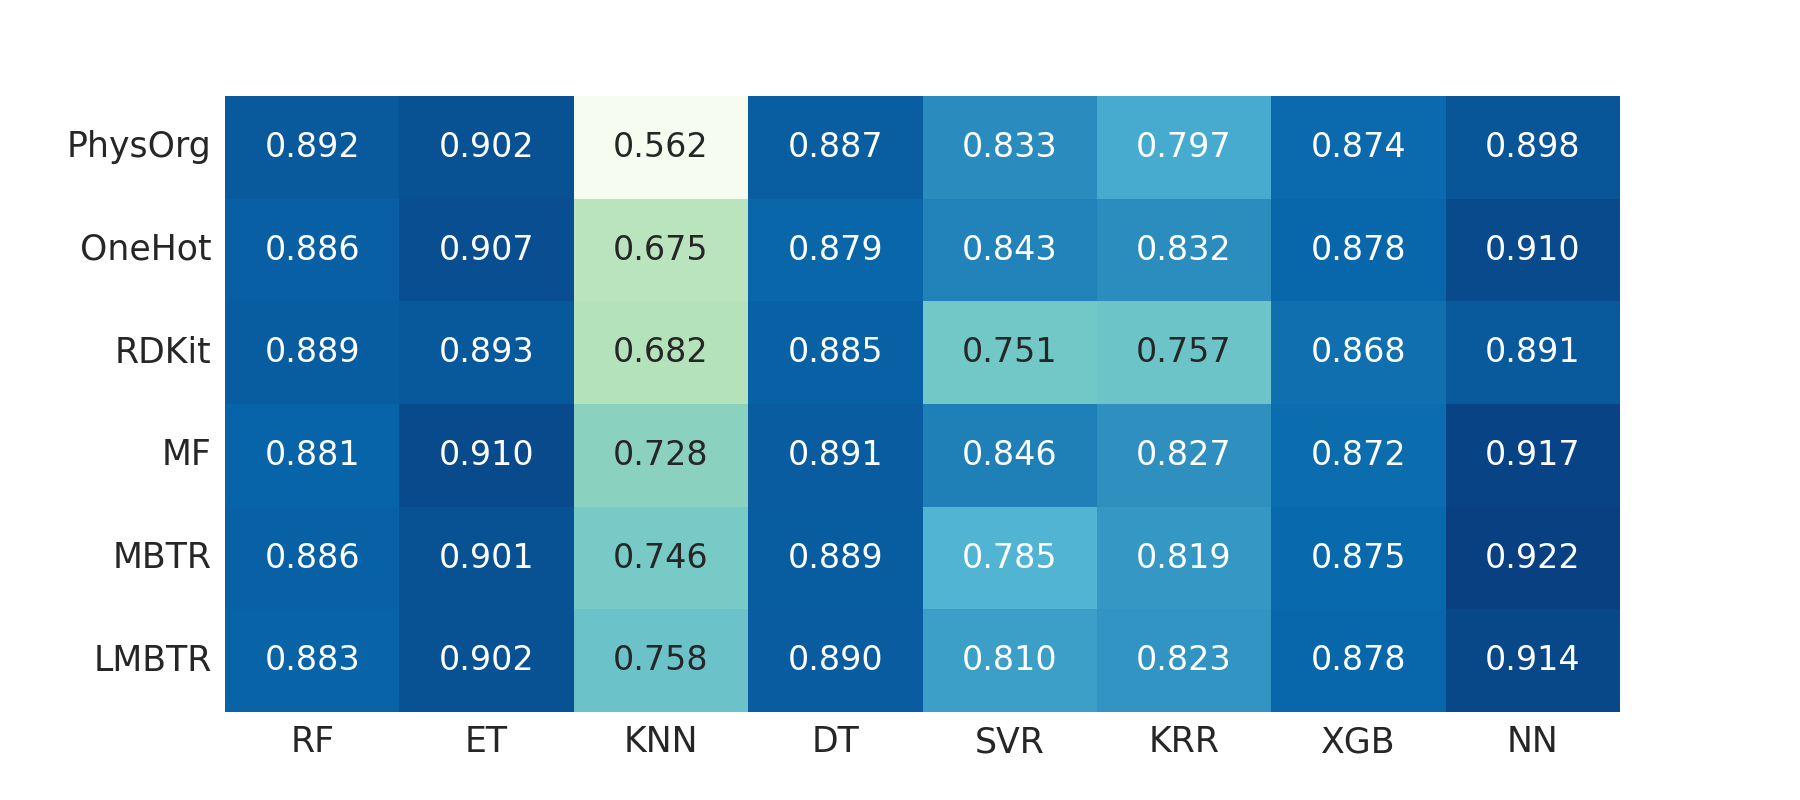

In [16]:
model_names = ['RF','ET','KNN','DT','SVR','KRR','XGB','NN']
desc_names = ['PhysOrg','OneHot','RDKit','MF','MBTR','LMBTR']
r2_map = np.zeros((len(desc_names),len(model_names)))
for i,m in enumerate(model_names):
    for j,d in enumerate(desc_names):
        
        r2_map[j,i] = performance_result[(m,d)][1]

fig = plt.figure(figsize=(18,8))
plt.yticks(rotation=90) ## As there are some bugs, please set rotation as 0 or 90 to correct orientation of descriptor tags
sns.set(font_scale=2)
sns.heatmap(r2_map,annot=True,fmt='.3f',xticklabels=model_names,yticklabels=desc_names,cmap='GnBu',cbar=False)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
print()

# Validate Model Extrapolative Ability

Identify the optimal machine learning model for every descriptor

In [19]:
performance_result = np.load('./results/models_descs_screening_10_fold.npy',allow_pickle=True).item()
best_params = np.load('./results/hyperparameters_opt.npy',allow_pickle=True).item()
model_names = ['RF','ET','KNN','DT','SVR','KRR','XGB','NN']

all_combinations = list(performance_result.keys())
best_model_for_specific_desc = [sorted([[item,performance_result[item][1]] for item in all_combinations \
                                        if item[1] == desc_name],key=lambda x:x[1])[-1] for desc_name in desc_names]
oos_performance = {} ## To store the OOS regression performance
best_model_for_specific_desc

[[('ET', 'PhysOrg'), 0.9021821426183451],
 [('NN', 'OneHot'), 0.910256081204299],
 [('ET', 'RDKit'), 0.8933106568187953],
 [('NN', 'MF'), 0.9172802777454118],
 [('NN', 'MBTR'), 0.9222743817909829],
 [('NN', 'LMBTR'), 0.913524450410554]]

ET-PhysOrg

In [20]:
model_name = 'ET'
desc_name = 'PhysOrg'
train_val_desc,train_val_target = physorg_react_desc[train_val_index],ddG[train_val_index]
oos_desc,oos_target = physorg_react_desc[test_index],ddG[test_index]

_,_,cv_mae,cv_r2,cv_pearson_r,_,_,oos_mae,oos_r2,oos_pearson_r = model_evaluation(train_val_desc,
    train_val_target,oos_desc,oos_target,best_params,model_name,desc_name,random_seed=random_seed)

oos_performance['%s/%s'%(model_name,desc_name)] = [oos_r2,oos_mae]

OneHot-NN

In [22]:
model_name = 'NN'
desc_name = 'OneHot'
train_val_desc,train_val_target = onehot_react_desc[train_val_index],ddG[train_val_index]
oos_desc,oos_target = onehot_react_desc[test_index],ddG[test_index]

_,_,cv_mae,cv_r2,cv_pearson_r,_,_,oos_mae,oos_r2,oos_pearson_r = model_evaluation(train_val_desc,
    train_val_target,oos_desc,oos_target,best_params,model_name,desc_name,random_seed=random_seed)

oos_performance['%s/%s'%(model_name,desc_name)] = [oos_r2,oos_mae]

ET-RDKit

In [23]:
model_name = 'ET'
desc_name = 'RDKit'
train_val_desc,train_val_target = rdkit_react_desc[train_val_index],ddG[train_val_index]
oos_desc,oos_target = rdkit_react_desc[test_index],ddG[test_index]

_,_,cv_mae,cv_r2,cv_pearson_r,_,_,oos_mae,oos_r2,oos_pearson_r = model_evaluation(train_val_desc,
    train_val_target,oos_desc,oos_target,best_params,model_name,desc_name,random_seed=random_seed)

oos_performance['%s/%s'%(model_name,desc_name)] = [oos_r2,oos_mae]

NN-MF

In [24]:
model_name = 'NN'
desc_name = 'MF'
train_val_desc,train_val_target = mf_react_desc[train_val_index],ddG[train_val_index]
oos_desc,oos_target = mf_react_desc[test_index],ddG[test_index]

_,_,cv_mae,cv_r2,cv_pearson_r,_,_,oos_mae,oos_r2,oos_pearson_r = model_evaluation(train_val_desc,
    train_val_target,oos_desc,oos_target,best_params,model_name,desc_name,random_seed=random_seed)

oos_performance['%s/%s'%(model_name,desc_name)] = [oos_r2,oos_mae]

NN-MBTR

In [25]:
model_name = 'NN'
desc_name = 'MBTR'
train_val_desc,train_val_target = mbtr_react_desc[train_val_index],ddG[train_val_index]
oos_desc,oos_target = mbtr_react_desc[test_index],ddG[test_index]

_,_,cv_mae,cv_r2,cv_pearson_r,_,_,oos_mae,oos_r2,oos_pearson_r = model_evaluation(train_val_desc,
    train_val_target,oos_desc,oos_target,best_params,model_name,desc_name,random_seed=random_seed)

oos_performance['%s/%s'%(model_name,desc_name)] = [oos_r2,oos_mae]

NN-LMBTR

In [26]:
model_name = 'NN'
desc_name = 'LMBTR'
train_val_desc,train_val_target = lmbtr_react_desc[train_val_index],ddG[train_val_index]
oos_desc,oos_target = lmbtr_react_desc[test_index],ddG[test_index]

_,_,cv_mae,cv_r2,cv_pearson_r,_,_,oos_mae,oos_r2,oos_pearson_r = model_evaluation(train_val_desc,
    train_val_target,oos_desc,oos_target,best_params,model_name,desc_name,random_seed=random_seed)

oos_performance['%s/%s'%(model_name,desc_name)] = [oos_r2,oos_mae]

In [27]:
oos_performance

{'ET/PhysOrg': [0.8218803248008726, 0.373766452485259],
 'NN/OneHot': [0.6385140699631884, 0.5685333764701036],
 'ET/RDKit': [0.5466184205243725, 0.5607458026352498],
 'NN/MF': [0.4975765153714288, 0.6437412063099236],
 'NN/MBTR': [0.3347173701956706, 0.6620286448368231],
 'NN/LMBTR': [0.4879701745574351, 0.599134761656618]}

## Visualization

<IPython.core.display.Javascript object>


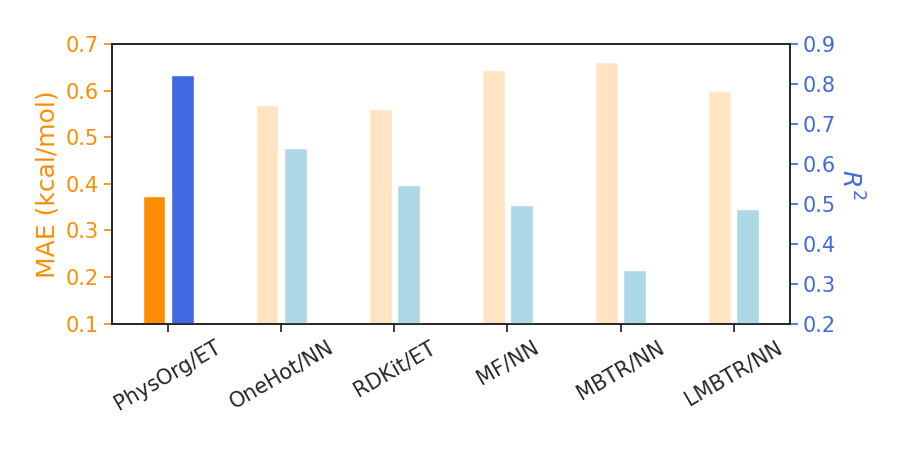

In [28]:
sns.set_style('white')
combinations = ['/'.join([item[0][0],item[0][1]]) for item in best_model_for_specific_desc]
oos_r2 = [oos_performance[key][0] for key in combinations]
oos_mae = [oos_performance[key][1] for key in combinations]

tickfontsize = 15
labelfontsize = 18

fig, ax1 = plt.subplots(figsize=(9,4.5))
ax2 = ax1.twinx()

ax1.bar([(i+1)*4-2 for i in range(len(oos_mae))],[item - 0.1 for item in oos_mae],
    color=['darkorange','bisque','bisque','bisque','bisque','bisque','bisque'])

ax1.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6])
ax1.set_yticklabels(['0.1','0.2','0.3','0.4','0.5','0.6','0.7'],fontsize=tickfontsize)

ax1.tick_params(axis='y',colors='darkorange')
ax1.set_xticks([(i+1)*4-1.5 for i in range(len(oos_mae))])
xtick_labels = ['/'.join([item.split('/')[1],item.split('/')[0]]) for item in combinations]
ax1.set_xticklabels(xtick_labels,fontsize=tickfontsize,rotation=30)

ax1.set_ylabel('MAE (kcal/mol)',fontsize=labelfontsize,color='darkorange')
ax1.tick_params(bottom='on')

ax2.bar([(i+1)*4-1 for i in range(len(oos_r2))], [item - 0.2 for item in oos_r2],
       color=['royalblue','lightblue','lightblue','lightblue','lightblue','lightblue','lightblue'])
ax2.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax2.set_yticklabels(['0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9'],fontsize=tickfontsize)
ax2.tick_params(axis='y',colors='royalblue')

ax2.set_ylabel('$R^2$',fontsize=labelfontsize,color='royalblue',rotation=270,labelpad=20)

plt.tick_params(bottom='on')
plt.tight_layout()

print()